# LSTM Stock Predictor Using Closing Prices

In this notebook, you will build and train a custom LSTM RNN that uses a 10 day window of Bitcoin closing prices to predict the 11th day closing price. 

You will need to:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model

## Data Preparation

In this section, you will need to prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

You will need to:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the X and y values
4. Reshape the X_train and X_test data for the model. Note: The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

In [2]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [3]:
# Load the stock prices
SP500_full = pd.read_csv('Resources/sp500_mom_short.csv', index_col='date',infer_datetime_format=True, parse_dates=True)
SP500_full.reset_index(inplace=True)
SP500_full['date']=SP500_full['date'].dt.date
# SP500_full.set_index(['date'],inplace=True)
SP500_full.index = pd.to_datetime(SP500_full['date'])
SP500_full.drop(columns=['date'],inplace=True)

SP500_full.tail()

,AMD,AMG,EQIX,JKHY,NEM,portfolio_value
date,,,,,,
2020-03-30,47.86,60.43,644.87,156.05,46.36,958.937465
2020-03-31,45.48,59.14,624.57,155.24,45.28,933.422204
2020-04-01,43.66,56.15,595.46,147.08,46.47,903.514428
2020-04-02,44.49,56.72,626.15,151.16,48.23,931.042205
2020-04-03,42.59,55.36,624.69,156.21,47.15,920.843062


In [4]:
#I am trimming the dataframe
#to the end of february. 
df=SP500_full.loc[:'2020-03-01']

In [5]:
# This function accepts the column number for the features (X) and the target (y):
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [6]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Try a window size anywhere from 1 to 10 and see how the model performance changes
#jjp - need to add a for loop 

# Creating the features (X) and target (y) data using the window_data() function.
window_size = 2

# Column index 1 is the `Close` column
feature_column = 5
target_column = 5
X, y = window_data(df, window_size, feature_column, target_column)

In [7]:
# Use 70% of the data for training and the remaineder for testing
# YOUR CODE HERE!
from sklearn.model_selection import train_test_split

split = int(0.7 *len(X))
X_train_rnn = X[: split -1]
X_test = X[split:]
y_train_rnn = y[: split -1]
y_test = y[split:]

X_train_rnn, X_val_rnn, y_train_rnn, y_val_rnn = train_test_split(X_train_rnn, y_train_rnn)

In [8]:
# Use MinMaxScaler to scale the data between 0 and 1. 
# YOUR CODE HERE!
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train_rnn =scaler.transform(X_train_rnn)
X_val_rnn =scaler.transform(X_val_rnn)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train_rnn = scaler.transform(y_train_rnn)
y_val_rnn = scaler.transform(y_val_rnn)
y_test =scaler.transform(y_test)

In [9]:
# Reshape the features for the model
# YOUR CODE HERE!
X_train_rnn = X_train_rnn.reshape((X_train_rnn.shape[0], X_train_rnn.shape[1], 1))
X_val_rnn = X_val_rnn.reshape((X_val_rnn.shape[0], X_val_rnn.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train_rnn[:5]} \n")
print (f"X_val_rnn sample values:\n{X_val_rnn[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.4512657 ]
  [0.44055155]]

 [[0.4151856 ]
  [0.37794777]]

 [[0.31001936]
  [0.32488867]]

 [[0.44391528]
  [0.44834719]]

 [[0.27086649]
  [0.26925926]]] 

X_val_rnn sample values:
[[[0.64074951]
  [0.63667901]]

 [[0.522734  ]
  [0.519189  ]]

 [[0.52978507]
  [0.52140459]]

 [[0.40231652]
  [0.40889853]]

 [[0.66482769]
  [0.66403314]]] 

X_test sample values:
[[[0.71198912]
  [0.70231599]]

 [[0.70231599]
  [0.72291133]]

 [[0.72291133]
  [0.72538546]]

 [[0.72538546]
  [0.74878022]]

 [[0.74878022]
  [0.73121125]]]


---

## Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN and fit (train) it using the training data.

You will need to:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

### Hints:
You will want to use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the FNG model vs the closing price model. 

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [11]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# YOUR CODE HERE!
model = Sequential()

number_units = 100
dropout_fraction = 0.7

#first layer:
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train_rnn.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
#second layer
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
#third layer
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# #fourth layer
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

#output layer
model.add(Dense(1))

In [12]:
# Compile the model
# YOUR CODE HERE!
model.compile(optimizer="adam", loss="mean_squared_error")

In [13]:
# Summarize the model
# YOUR CODE HERE!
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2, 100)            40800     
_________________________________________________________________
dropout (Dropout)            (None, 2, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 2, 100)            80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 2, 100)            80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 100)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               8

In [14]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
# YOUR CODE HERE!
batch_size = 60
epochs = 250
model.fit(
    X_train_rnn,
    y_train_rnn,
    validation_data=(X_val_rnn, y_val_rnn),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

Train on 646 samples, validate on 216 samples
Epoch 1/250
646/646 [==============================] - 5s 8ms/sample - loss: 0.2446 - val_loss: 0.1844
Epoch 2/250
646/646 [==============================] - 0s 209us/sample - loss: 0.0979 - val_loss: 0.0254
Epoch 3/250
646/646 [==============================] - 0s 193us/sample - loss: 0.0463 - val_loss: 0.0276
Epoch 4/250
646/646 [==============================] - 0s 190us/sample - loss: 0.0394 - val_loss: 0.0278
Epoch 5/250
646/646 [==============================] - 0s 185us/sample - loss: 0.0330 - val_loss: 0.0185
Epoch 6/250
646/646 [==============================] - 0s 177us/sample - loss: 0.0297 - val_loss: 0.0172
Epoch 7/250
646/646 [==============================] - 0s 187us/sample - loss: 0.0246 - val_loss: 0.0080
Epoch 8/250
646/646 [==============================] - 0s 173us/sample - loss: 0.0203 - val_loss: 0.0043
Epoch 9/250
646/646 [==============================] - 0s 164us/sample - loss: 0.0156 - val_loss: 0.0032
Epoch 10/25

---

## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [15]:
# Evaluate the model
# YOUR CODE HERE!
model.evaluate(X_test, y_test)

370/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.0008535964338964707

In [16]:
X_train_rnn.shape

(646, 2, 1)

In [20]:
seq = df[df.columns[feature_column]][-2:].tolist()
forecast=[]
for i in range (5):
    prediction = model.predict([np.array(seq).reshape(1,X_train_rnn.shape[1],1)])
    seq.append(prediction[0][0])
    seq.pop(0)
    forecast.append([prediction[0][0]])

In [21]:
forecast_scaled=scaler.inverse_transform(forecast)

In [22]:
fwd_prices=forecast_scaled.ravel()

In [23]:
# Make some predictions
# YOUR CODE HERE!
predicted = model.predict(X_test)

In [24]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [25]:
# Create a DataFrame of Real and Predicted values
stock_closing = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
})
stock_closing.head()

,Real,Predicted
0,959.714599,942.289551
1,960.975965,942.041870
2,972.903084,949.112854
3,963.946068,953.215149
4,982.537176,958.341125


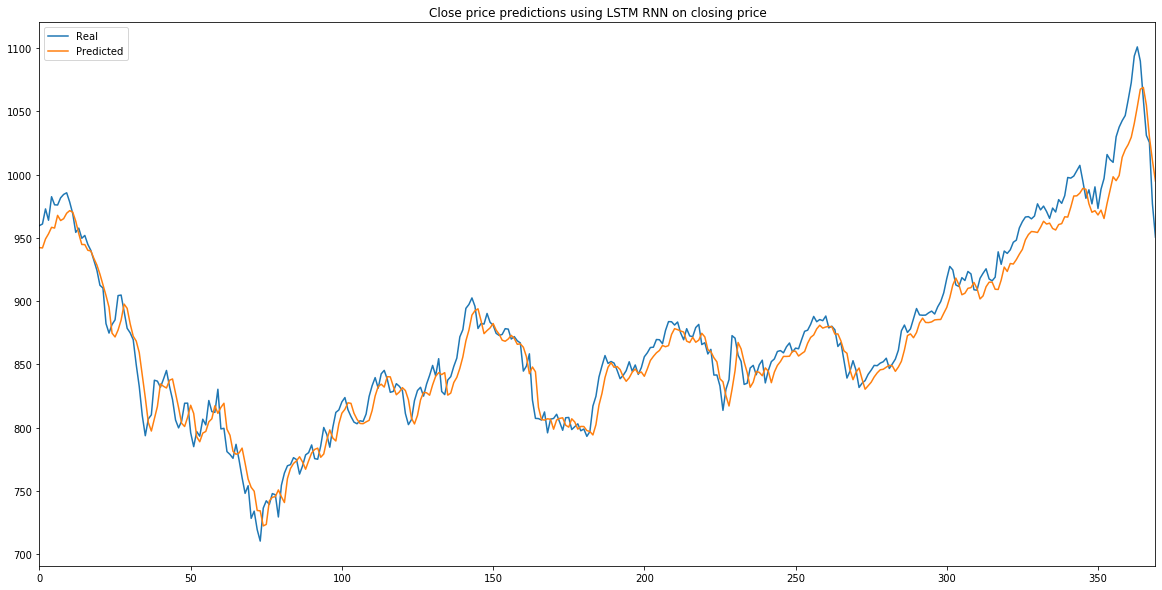

In [27]:
# Plot the real vs predicted values as a line chart
# YOUR CODE HERE!
stock_closing.plot(title='Close price predictions using LSTM RNN on closing price',figsize=(20,10))

In [28]:
real_prices=SP500_full[SP500_full.columns[feature_column]]['2020-03-02':'2020-03-07'].tolist()

In [29]:
A=SP500_full.loc['2020-03-02':'2020-03-06'].index

In [30]:
out_of_sample=pd.DataFrame({'Real_Prices':real_prices,
                          'Look_Fwd_Prices':fwd_prices},
                          index=A)
#                            index=['2020-03-02','2020-03-03','2020-03-04','2020-03-05','2020-03-06'])

In [31]:
out_of_sample

,Real_Prices,Look_Fwd_Prices
date,,
2020-03-02,1000.000000,980.735300
2020-03-03,995.393589,990.533827
2020-03-04,1038.476181,970.590293
2020-03-05,1012.783297,971.333211
2020-03-06,1008.364852,958.902050


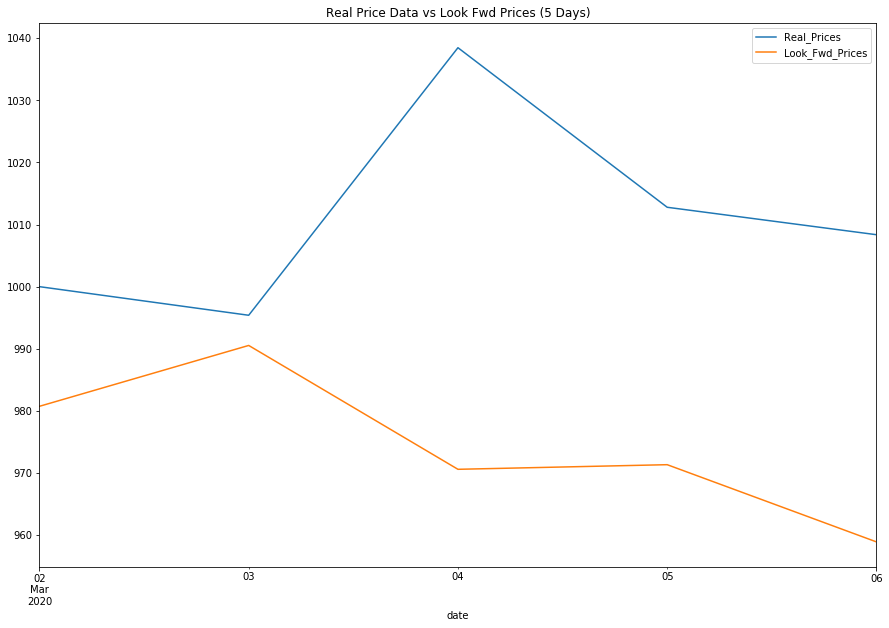

In [32]:
out_of_sample.plot(figsize=(15,10), title='Real Price Data vs Look Fwd Prices (5 Days)')

In [33]:
look_fwd=pd.concat([SP500_full[SP500_full.columns[feature_column]][:'2020-03-06'],out_of_sample],axis=1,join='outer')
# df[df.columns[feature_column]]

In [34]:
# SP500_full[SP500_full.columns[feature_column]][:'2020-03-06']

In [35]:
# look_fwd['CHECK']=SP500_full[SP500_full.columns[feature_column]][:'2020-03-06']

In [36]:
look_fwd_2020=look_fwd.iloc[-90:]

In [37]:
# look_fwd_2020.drop(columns='CHECK',inplace=True)

In [38]:
look_fwd_2020.drop(columns=['Real_Prices'], inplace=True)
look_fwd_2020

C:\Users\mrich\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,portfolio_value,Look_Fwd_Prices
date,,
2019-10-28,876.527181,NaN
2019-10-29,881.093964,NaN
2019-10-30,875.235610,NaN
2019-10-31,878.069564,NaN
2019-11-01,886.155990,NaN
...,...,...
2020-03-02,1000.000000,980.735300
2020-03-03,995.393589,990.533827
2020-03-04,1038.476181,970.590293


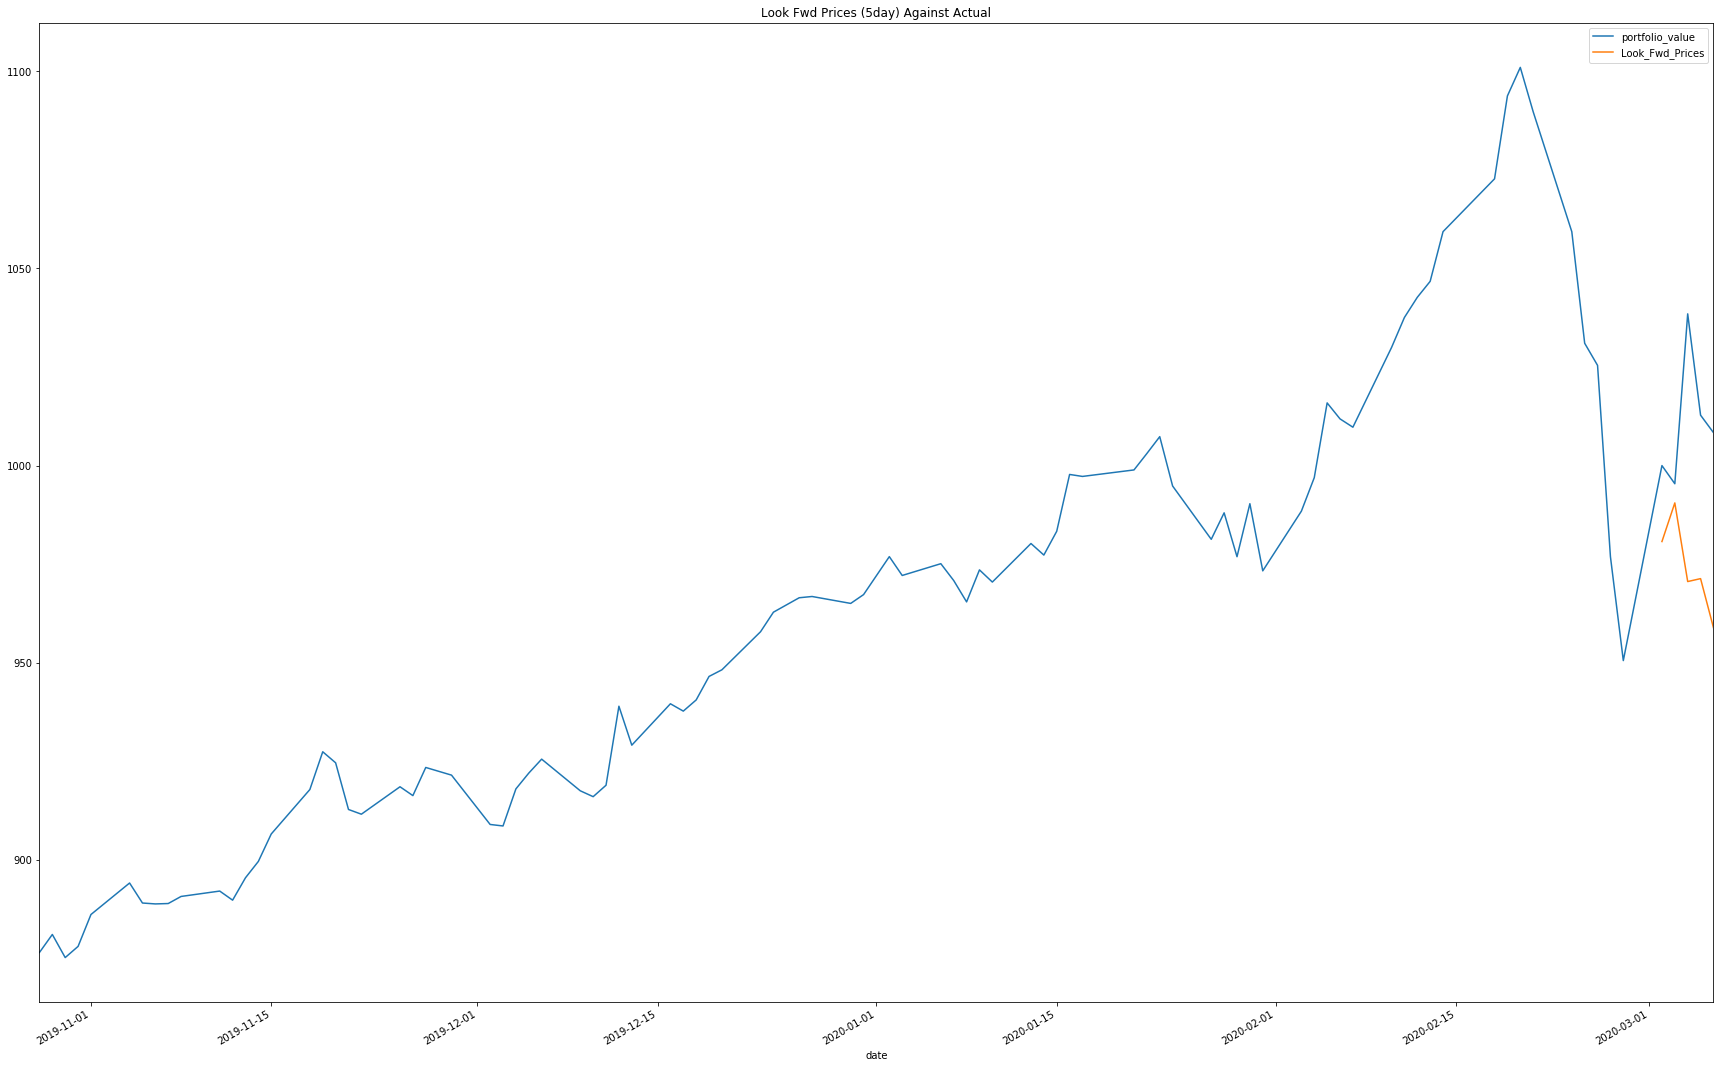

In [39]:
look_fwd_2020.plot(figsize=(30,20),title='Look Fwd Prices (5day) Against Actual')